## Otimização de Portfolio - Modelo Brandt

In [115]:
import numpy as np
import pandas as pd
import scipy as sp
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt

In [116]:
str_dir = 'C:/Users/nelly/Desktop/Mestrado Insper/DISSERTAÇÃO/Dissertação/Modelo/'

In [117]:
str_plan_ibov_w = 'Ibov_W'

df_ibov_w = pd.read_csv(filepath_or_buffer = str_dir + str_plan_ibov_w + '.csv', sep=';')
df_ibov_w.index = df_ibov_w['Data']
df_ibov_w.index = pd.to_datetime(df_ibov_w['Data'])
df_ibov_w = df_ibov_w.drop(columns=['Data'])
df_ibov_w = df_ibov_w.dropna()
df_ibov_w.head()

,VALE3 BS Equity,B3SA3 BS Equity,ITUB4 BS Equity,PETR4 BS Equity,BBDC4 BS Equity,PETR3 BS Equity,ABEV3 BS Equity,MGLU3 BS Equity,WEGE3 BS Equity,BBAS3 BS Equity,...,MRVE3 BS Equity,ENBR3 BS Equity,CPFE3 BS Equity,USIM5 BS Equity,BEEF3 BS Equity,CVCB3 BS Equity,IGTA3 BS Equity,GOLL4 BS Equity,ECOR3 BS Equity,HGTX3 BS Equity
Data,,,,,,,,,,,,,,,,,,,,,
2013-12-31,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,...,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133
2014-01-01,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,...,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133
2014-02-01,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,...,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133
2014-03-01,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,...,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133
2014-06-01,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,...,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133,0.0133


In [118]:
str_pe_ratio = 'PE_Ratio'

df_PE_Ratio = pd.read_csv(filepath_or_buffer = str_dir + str_pe_ratio + '.csv', sep=';')
df_PE_Ratio.index = df_PE_Ratio['Data']
df_PE_Ratio.index = pd.to_datetime(df_PE_Ratio['Data'])
df_PE_Ratio = df_PE_Ratio.drop(columns=['Data'])
df_PE_Ratio = df_PE_Ratio.dropna()
df_PE_Ratio.head()

,VALE3 BS Equity,B3SA3 BS Equity,ITUB4 BS Equity,PETR4 BS Equity,BBDC4 BS Equity,PETR3 BS Equity,ABEV3 BS Equity,MGLU3 BS Equity,WEGE3 BS Equity,BBAS3 BS Equity,...,MRVE3 BS Equity,ENBR3 BS Equity,CPFE3 BS Equity,USIM5 BS Equity,BEEF3 BS Equity,CVCB3 BS Equity,IGTA3 BS Equity,GOLL4 BS Equity,ECOR3 BS Equity,HGTX3 BS Equity
Data,,,,,,,,,,,,,,,,,,,,,
2013-12-31,1551.1,19.6,9.5,9.5,10.2,8.8,24.3,12.4,25.2,4.4,...,8.6,14.4,19.6,31.7,15.9,17.8,21.1,19.4,20.8,15.5
2014-01-01,1551.1,19.6,9.5,9.5,10.2,8.8,24.3,12.4,25.2,4.4,...,8.6,14.4,19.6,31.7,15.9,17.8,21.1,19.4,20.8,15.5
2014-02-01,1512.0,18.8,9.6,9.3,10.1,8.8,24.4,11.9,24.6,4.3,...,8.0,14.0,19.0,31.7,15.9,18.2,20.8,19.4,20.6,15.2
2014-03-01,1468.5,19.0,9.5,9.1,10.0,8.5,23.7,12.3,24.3,4.4,...,8.6,14.6,18.9,31.7,15.9,18.5,21.1,19.4,20.0,15.5
2014-06-01,1480.7,18.5,9.6,9.2,10.1,8.7,23.6,13.0,24.5,4.3,...,8.5,14.2,19.0,31.7,15.9,18.6,21.1,19.4,19.4,15.1


In [119]:
str_pb_ratio = 'PB_Ratio'

df_PB_Ratio = pd.read_csv(filepath_or_buffer = str_dir + str_pb_ratio + '.csv', sep=';')
df_PB_Ratio.index = df_PB_Ratio['Data']
df_PB_Ratio.index = pd.to_datetime(df_PB_Ratio['Data'])
df_PB_Ratio = df_PB_Ratio.drop(columns=['Data'])
df_PB_Ratio = df_PB_Ratio.dropna()
df_PB_Ratio.head()

,VALE3 BS Equity,B3SA3 BS Equity,ITUB4 BS Equity,PETR4 BS Equity,BBDC4 BS Equity,PETR3 BS Equity,ABEV3 BS Equity,MGLU3 BS Equity,WEGE3 BS Equity,BBAS3 BS Equity,...,MRVE3 BS Equity,ENBR3 BS Equity,CPFE3 BS Equity,USIM5 BS Equity,BEEF3 BS Equity,CVCB3 BS Equity,IGTA3 BS Equity,GOLL4 BS Equity,ECOR3 BS Equity,HGTX3 BS Equity
Data,,,,,,,,,,,,,,,,,,,,,
2013-12-31,1.24,1.11,1.84,0.64,1.72,0.60,6.31,2.00,4.24,0.99,...,0.90,1.18,2.62,0.84,3.77,6.28,1.69,4.46,3.99,5.43
2014-01-01,1.24,1.11,1.84,0.64,1.72,0.60,6.31,2.00,4.24,0.99,...,0.90,1.18,2.62,0.84,3.77,6.28,1.69,4.46,3.99,5.43
2014-02-01,1.21,1.06,1.85,0.63,1.71,0.59,6.34,1.92,4.14,0.97,...,0.84,1.15,2.53,0.79,3.68,6.42,1.67,4.31,3.96,5.33
2014-03-01,1.17,1.07,1.84,0.62,1.69,0.58,6.16,1.98,4.08,0.98,...,0.91,1.20,2.52,0.82,3.73,6.52,1.70,4.54,3.83,5.44
2014-06-01,1.18,1.04,1.85,0.62,1.71,0.59,6.12,2.08,4.12,0.97,...,0.89,1.17,2.53,0.83,3.66,6.56,1.69,4.60,3.72,5.29


In [120]:
str_ret_ibov = 'Ret_Ibov'

df_Ret_Ibov = pd.read_csv(filepath_or_buffer = str_dir + str_ret_ibov + '.csv', sep=';')
df_Ret_Ibov.index = df_Ret_Ibov['Data']
df_Ret_Ibov.index = pd.to_datetime(df_Ret_Ibov['Data'])
df_Ret_Ibov = df_Ret_Ibov.drop(columns=['Data'])
df_Ret_Ibov = df_Ret_Ibov.dropna()
df_Ret_Ibov.head()

,VALE3 BS Equity,B3SA3 BS Equity,ITUB4 BS Equity,PETR4 BS Equity,BBDC4 BS Equity,PETR3 BS Equity,ABEV3 BS Equity,MGLU3 BS Equity,WEGE3 BS Equity,BBAS3 BS Equity,...,MRVE3 BS Equity,ENBR3 BS Equity,CPFE3 BS Equity,USIM5 BS Equity,BEEF3 BS Equity,CVCB3 BS Equity,IGTA3 BS Equity,GOLL4 BS Equity,ECOR3 BS Equity,HGTX3 BS Equity
Data,,,,,,,,,,,,,,,,,,,,,
2013-12-31,-0.022442,-0.012934,-0.019037,0.016137,0.014955,0.036344,-0.001928,-0.005947,-0.013236,-0.006364,...,-0.014450,-0.000805,0.049905,0.000562,-0.011839,0.013405,-0.011727,0.001104,0.018757,-0.006698
2014-01-01,-0.019336,-0.029246,0.014730,-0.000203,-0.023899,0.028131,0.017509,0.028666,0.001332,0.003288,...,0.000471,-0.000073,0.025929,0.026189,0.002832,0.003111,-0.024096,0.034483,0.002595,0.002125
2014-02-01,-0.025681,0.001712,-0.015930,-0.010395,-0.014732,-0.014811,-0.006038,-0.013046,0.004212,0.033301,...,0.013801,-0.030182,-0.023202,0.007554,0.001703,0.001662,-0.010102,-0.036253,0.002895,-0.025148
2014-03-01,0.004711,0.042734,-0.017134,0.025025,-0.039501,-0.002547,-0.000258,0.003221,0.001431,-0.040717,...,-0.035727,0.004017,0.015412,0.017570,-0.031770,0.010259,0.000385,0.027184,0.024022,-0.069563
2014-06-01,-0.025665,0.006446,0.007576,-0.017205,-0.064838,-0.004564,0.018644,0.001664,0.022320,0.027805,...,0.012060,0.008172,-0.039012,0.011840,-0.002783,0.002330,0.002741,-0.006227,-0.004298,0.008205


In [121]:
mu = np.mean(df_Ret_Ibov)*252

cov = df_Ret_Ibov.cov()*252

In [122]:
N_t = len(df_Ret_Ibov.columns)

C:\Users\nelly\anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


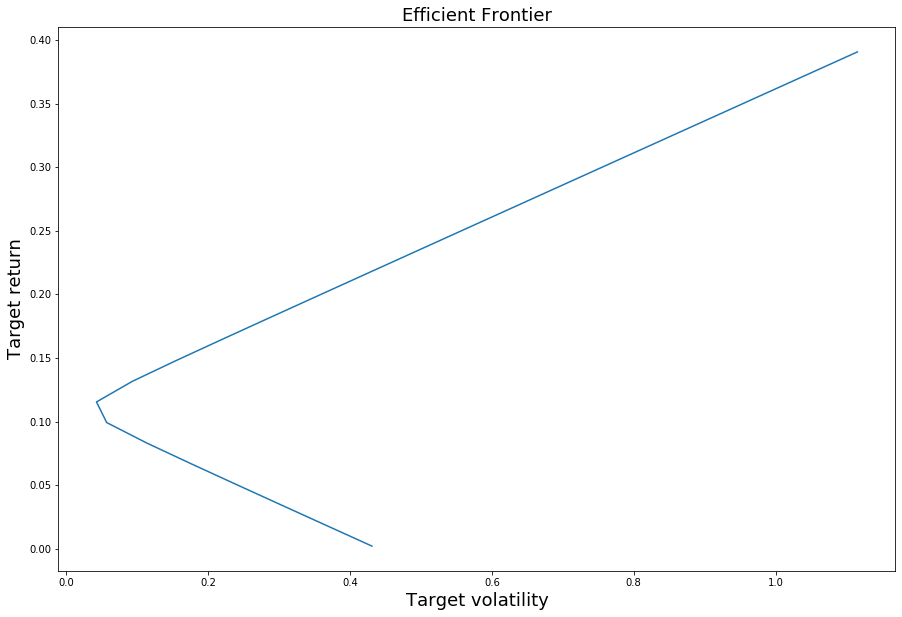

In [128]:
def get_port(rp,mu,cov):
    
    theta0 = np.array(pd.DataFrame([0,0]))
    
    x_t = np.array(pd.concat([df_PE_Ratio.iloc[0,:],df_PB_Ratio.iloc[0,:]], axis=1).T)
    
    mean_variance = lambda theta : (df_ibov_w.iloc[0,:] + (1/N_t) * np.array(theta).dot(x_t)).dot(cov).dot(df_ibov_w.iloc[0,:] + \
                                                                                                (1/N_t) * np.array(theta).dot(x_t))
    
    
    eq_cons = ({'type': 'eq', 'fun': lambda theta: (df_ibov_w.iloc[0,:] + (1/N_t) * np.array(theta).dot(x_t)).sum() - 1},
               {'type': 'eq', 'fun': lambda theta: (df_ibov_w.iloc[0,:] + (1/N_t) * np.array(theta).dot(x_t)).dot(mu)- rp})

    
    res = opt.minimize(mean_variance, theta0, method='SLSQP', constraints= eq_cons)
    
    
    theta = pd.Series(data=res.x)
    
    w = (df_ibov_w.iloc[0,:] + (1/N_t) * np.array(theta).dot(x_t))

    return w, np.sqrt(res.fun)


weights_df = pd.DataFrame()
frontier = pd.Series()

for rp in np.linspace(0.002, mu.max(), 25):
    w, s = get_port(rp,mu,cov)
    weights_df = weights_df.append(w.T)
    frontier[s] = rp
    
frontier.plot(figsize=(15,10))
plt.title('Efficient Frontier',fontsize=18)
plt.ylabel('Target return',fontsize=18)
plt.xlabel('Target volatility',fontsize=18)
plt.show()

In [127]:
pd.concat([df_PE_Ratio.iloc[0,:],df_PB_Ratio.iloc[0,:]],axis=1).T

,VALE3 BS Equity,B3SA3 BS Equity,ITUB4 BS Equity,PETR4 BS Equity,BBDC4 BS Equity,PETR3 BS Equity,ABEV3 BS Equity,MGLU3 BS Equity,WEGE3 BS Equity,BBAS3 BS Equity,...,MRVE3 BS Equity,ENBR3 BS Equity,CPFE3 BS Equity,USIM5 BS Equity,BEEF3 BS Equity,CVCB3 BS Equity,IGTA3 BS Equity,GOLL4 BS Equity,ECOR3 BS Equity,HGTX3 BS Equity
2013-12-31,1551.10,19.60,9.50,9.50,10.20,8.8,24.30,12.4,25.20,4.40,...,8.6,14.40,19.60,31.70,15.90,17.80,21.10,19.40,20.80,15.50
2013-12-31,1.24,1.11,1.84,0.64,1.72,0.6,6.31,2.0,4.24,0.99,...,0.9,1.18,2.62,0.84,3.77,6.28,1.69,4.46,3.99,5.43


In [126]:
 theta = pd.DataFrame([0,0]).T

(df_ibov_w.iloc[0,:] + (1/N_t) * theta.dot(pd.concat([df_PE_Ratio.iloc[0,:],df_PB_Ratio.iloc[0,:]],axis=1))).dot(cov).dot(df_ibov_w.iloc[0,:] + (1/N_t) * theta.dot(pd.concat([df_PE_Ratio.iloc[0,:],
                                                                                        df_PB_Ratio.iloc[0,:]], 
                                                                                        axis=1)))

ValueError: matrices are not aligned

In [124]:
x_t = pd.concat([df_PE_Ratio.iloc[0,:],df_PB_Ratio.iloc[0,:]], axis=1).T

np.array(theta).dot(np.array(x_t))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [125]:
print(x_t)

            VALE3 BS Equity  B3SA3 BS Equity  ITUB4 BS Equity  \
2013-12-31          1551.10            19.60             9.50   
2013-12-31             1.24             1.11             1.84   

            PETR4 BS Equity  BBDC4 BS Equity  PETR3 BS Equity  \
2013-12-31             9.50            10.20              8.8   
2013-12-31             0.64             1.72              0.6   

            ABEV3 BS Equity  MGLU3 BS Equity  WEGE3 BS Equity  \
2013-12-31            24.30             12.4            25.20   
2013-12-31             6.31              2.0             4.24   

            BBAS3 BS Equity  ...  MRVE3 BS Equity  ENBR3 BS Equity  \
2013-12-31             4.40  ...              8.6            14.40   
2013-12-31             0.99  ...              0.9             1.18   

            CPFE3 BS Equity  USIM5 BS Equity  BEEF3 BS Equity  \
2013-12-31            19.60            31.70            15.90   
2013-12-31             2.62             0.84             3.77   

     